In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

sns.set_style("whitegrid")
sns.set_context("talk")
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1

In [2]:
# Create input features
np.random.seed(11)
nyear = 120
tall = np.arange(1,nyear*12,1)/12

x1 = tall /nyear
x2 = np.sin(2*np.pi/40*tall) 

fsize=7*12
x3 = np.convolve(.9*np.random.randn(tall.size+fsize-1),np.ones(fsize)/fsize,'valid')

Xall = np.vstack((x1,x2,x3)).T
Xall += .05*np.random.randn(*Xall.shape)



ytrue = -.5*x1 + .2*x2 + .2*x3 
nsize=15
yall = ytrue + np.convolve(.2*np.random.randn(tall.size+nsize-1),np.ones(nsize)/nsize,'valid')

In [3]:
mask_test = tall>100
t = tall[~mask_test]
X = Xall[~mask_test]
y = yall[~mask_test]

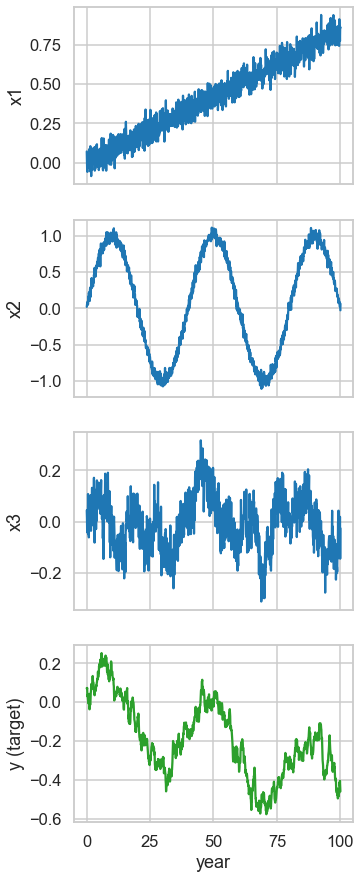

In [4]:
fig, ax = plt.subplots(nrows=X.shape[1]+1,sharex=True,figsize=(5,15))
for i in range(X.shape[1]):
    ax[i].plot(t,X[:,i])
    ax[i].set_ylabel(f'x{i+1}')
ax[-1].plot(t,y,color='C2')
ax[-1].set_ylabel('y (target)')
ax[-1].set_xlabel('year')

fig.savefig('figs/leak_data.png')

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
score = make_scorer(mean_squared_error)


np.random.seed(13)
nval = int(0.2*t.size)
indx_val = np.random.permutation(t.size)[:nval]
mask_val = np.zeros(t.size,bool)
mask_val[indx_val] = True
mask_train = ~mask_val
mask_train

array([False,  True,  True, ..., False,  True,  True])

In [38]:
y[mask_val].shape

(240,)

In [39]:
dmax = 8

pipeline = dict()
score_d = np.nan*np.ones(dmax)

for d in range(1,dmax+1):
    poly = PolynomialFeatures(degree=d)
    clf = linear_model.LinearRegression()
    pipeline[d] = Pipeline(steps=[('prep',poly),('lin',clf)])
    pipeline[d].fit(X[mask_train], y[mask_train])
    score_d[d-1] = score(pipeline[d],X[mask_val],y[mask_val])
    print(f'{d}:{score_d[d-1]:.2e}')

1:3.91e-03
2:3.80e-03
3:3.60e-03
4:8.44e-03
5:3.10e-03
6:3.28e-03
7:3.02e-03
8:4.03e-03


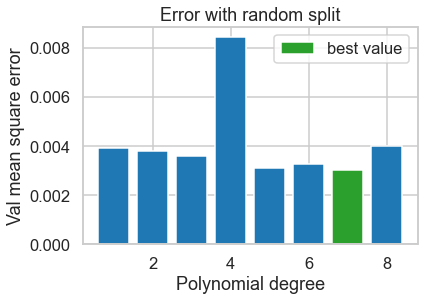

In [40]:
plt.bar(range(1,dmax+1),score_d)
imin = np.argmin(score_d)
plt.bar(imin+1,score_d[imin],color='C2',label='best value')
plt.xlabel('Polynomial degree')
plt.ylabel('Val mean square error')
plt.legend()
plt.title('Error with random split')
plt.savefig('figs/leak_bar_random.png')

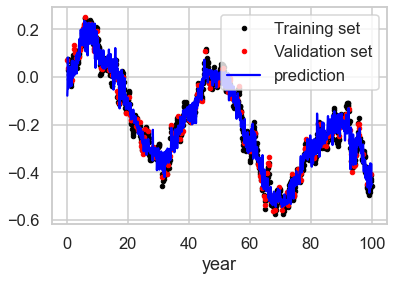

In [42]:
y_pred = pipeline[7].predict(X)

plt.plot(t[mask_train],y[mask_train],'.k',label='Training set')
plt.plot(t[mask_val],y[mask_val],'.r',label='Validation set')
plt.xlabel('year')
plt.savefig('figs/leak_ts_random_nopred.png')

plt.plot(t,y_pred,'-b',label='prediction')
plt.legend()
plt.savefig('figs/leak_ts_random.png')

In [43]:
ypred_test = pipeline[7].predict(Xall[mask_test])

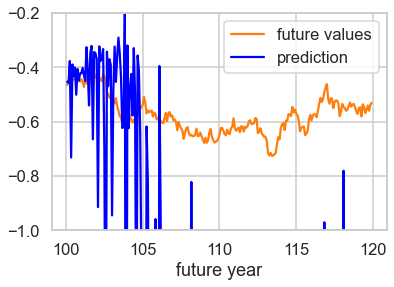

In [44]:
plt.plot(tall[mask_test],yall[mask_test],color='C1',label='future values')

plt.plot(tall[mask_test],ypred_test,color='b',label='prediction')
plt.ylim([-1,-.2])
plt.legend()
plt.xlabel('future year')
plt.savefig('figs/leak_test_random.png')

In [45]:
mask_val = np.zeros(t.size,bool)
mask_val[-nval:] = True
mask_train = ~mask_val
mask_train

array([ True,  True,  True, ..., False, False, False])

In [46]:
dmax = 9

pipeline = dict()
score_d = np.nan*np.ones(dmax)

for d in range(1,dmax+1):
    poly = PolynomialFeatures(degree=d)
    clf = linear_model.LinearRegression()
    pipeline[d] = Pipeline(steps=[('prep',poly),('lin',clf)])
    pipeline[d].fit(X[mask_train], y[mask_train])
    score_d[d-1] = score(pipeline[d],X[mask_val],y[mask_val])
    print(f'{d}:{score_d[d-1]:.2e}')

1:4.81e-03
2:1.04e-02
3:1.26e-01
4:1.10e-01
5:3.69e-01
6:6.02e-01
7:5.14e+01
8:2.54e+03
9:6.95e+03


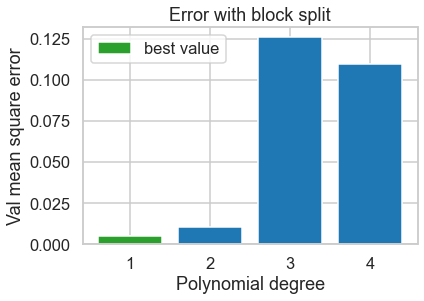

In [47]:
plt.bar(range(1,5),score_d[:4])
imin = np.argmin(score_d)
plt.bar(imin+1,score_d[imin],color='C2',label='best value')
plt.xlabel('Polynomial degree')
plt.ylabel('Val mean square error')
plt.legend()
plt.title('Error with block split')
plt.savefig('figs/leak_bar_block.png')

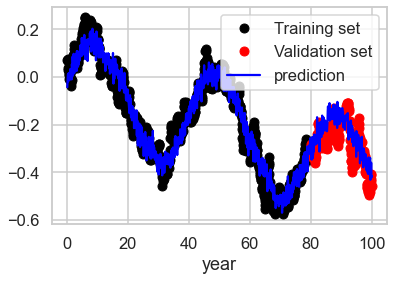

In [49]:
y_pred = pipeline[1].predict(X)

plt.plot(t[mask_train],y[mask_train],'.k',label='Training set')
plt.plot(t[mask_val],y[mask_val],'or',label='Validation set')
plt.xlabel('year')
plt.savefig('figs/leak_ts_block_nopred.png')

plt.plot(t,y_pred,'-b',label='prediction')
plt.legend()

plt.savefig('figs/leak_ts_block.png')

In [16]:
ypred_test = pipeline[1].predict(Xall[mask_test])

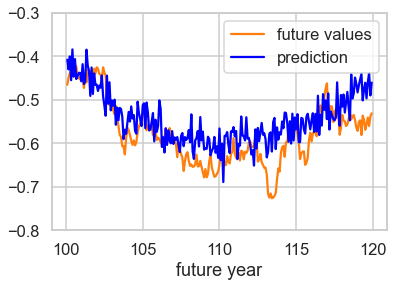

In [17]:
plt.plot(tall[mask_test],yall[mask_test],color='C1',label='future values')

plt.plot(tall[mask_test],ypred_test,color='b',label='prediction')
plt.ylim([-.8,-.3])
plt.legend()
plt.xlabel('future year')
plt.savefig('figs/leak_test_block.png')